### Computer Vision Internship Program



#### Practical Task description:
Your task is to write to a pipeline to classify images from MNIST dataset
(http://yann.lecun.com/exdb/mnist/)  using Neural Networks!




##### To complete this task, you will have to implement the following steps:
<br> 1. Download and read the data - 10 points
<br> 2. Show how you use augmentation functions. To get the points, visualize the original image vs augmented image using 4 augmentation techniques of your choice - 10 points
<br> 3. Implement a Neural Network which classifies given images. You can use any deep learning framework - 10 points
<br> 4. Implement a training procedure using your dataloader, augmentation functions and neural network - 10 points
<br> 5. Plot loss graph - 10 points
<br> 6. Print accuracy of your model on test set -  10 points
<br> 7. Show us how your model works! Plot a few input images and corresponding predictions of your model - 10 points
<br> 8. Upload your work to github - 5 points. Google/dropbox/yandex drive - 0 points

Max = 75 points!

##### Main notes:
<br> *- implement your work in provided jupyter notebook 
<br> - you can use any framework 
<br> - we are not too strict about the requirements: if your work corresponds to the task wording, the chances are you will get the full points*


Please, upload to a google/dropbox/yandex drive or github  and send the link to the following google form: https://docs.google.com/forms/d/e/1FAIpQLSeeYILriugs1Vdxa3r01nS1469VT-_t_ZCNF18zwQVl-XKkHQ/viewform?usp=sf_link 

If you have any questions, please mail to:
olzhas.kabdolov@btsdigital.kz and rustem.burkhanov@btsdigital.kz 

**The deadline is 27th of May, 12 o'Clock in the noon**


####  Good luck and have fun!


##### Task 1. Dataloader

In [151]:
# !wget "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz" 
# !wget "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz" 
# !wget "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz" 
# !wget "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz" 
import gzip
import numpy as np
train_img_filename = 'train-images-idx3-ubyte.gz'
train_lbl_filename = 'train-labels-idx1-ubyte.gz'
test_img_filename = 't10k-images-idx3-ubyte.gz'
test_lbl_filename = 't10k-labels-idx1-ubyte.gz'

image_size = 28
num_train = 60000
num_test = 10000

def read_data(img_path,lbl_path,num):
    imgs = gzip.open(img_path,'r')
    lbls = gzip.open(lbl_path,'r')
    imgs.read(16)
    buf = imgs.read(image_size * image_size * num)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    img_data = data.reshape(num, 1,image_size, image_size)/255
    lbls.read(8)
    buf = lbls.read(num)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.uint8)
    lbl_data = data.reshape(num)
    return img_data, lbl_data


train_img,train_lbl = read_data(train_img_filename,train_lbl_filename,num_train)
print("train_img shape: ",train_img.shape)
print("train_lbl shape: ",train_lbl.shape)
test_img, test_lbl = read_data(test_img_filename,test_lbl_filename,num_test)
print("test_img shape: ",test_img.shape)
print("test_lbl shape: ",test_lbl.shape)


train_img shape:  (60000, 1, 28, 28)
train_lbl shape:  (60000,)
test_img shape:  (10000, 1, 28, 28)
test_lbl shape:  (10000,)


##### Task 2. Augmentation

In [152]:
import matplotlib.pyplot as plt

In [153]:
from skimage.transform import rescale,rotate,resize
from skimage.util import random_noise
from skimage import exposure
from scipy import ndimage
import random

In [154]:
def show(original, augmented):
    plt.subplot(121)
    plt.imshow(original.reshape(image_size,image_size))
    plt.subplot(122)
    plt.imshow(augmented.reshape(image_size,image_size))
    plt.show()

In [155]:
#rescale and fit the size to the same dimentions

def augmentor1(orig):
    '''
    rescale and fit 
    '''
    return resize(rescale(orig,0.95),(1,image_size,image_size))
def augmentor2(orig):
    '''
    random rotations
    '''
    return rotate(orig,random.randint(-5,5),center=(random.randint(10,20),random.randint(10,20)),resize=False)
def augmentor3(orig):
    '''
    salt and paper noise
    '''
    return random_noise(orig,'s&p',amount=0.01)
def augmentor4(orig):
    '''
    intensity change
    '''
    v_min, v_max = np.percentile(orig, (0.02, 95.8))
    return exposure.rescale_intensity(orig, in_range=(v_min, v_max))
def augmentor5(orig):
    '''
    filtering
    '''
    return ndimage.uniform_filter(orig, size=(1,3, 3))



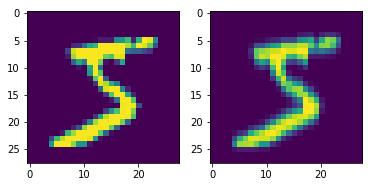

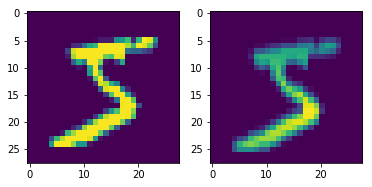

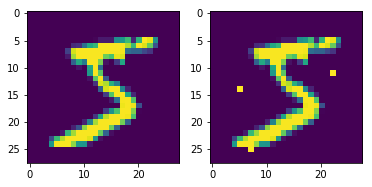

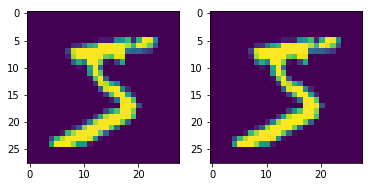

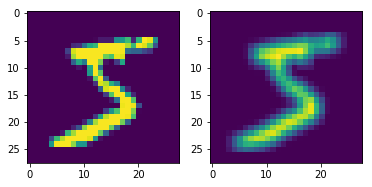

In [156]:
orig = train_img[0]
aug = augmentor1(orig)
show(orig,aug)
aug = augmentor2(orig)
show(orig,aug)
aug = augmentor3(orig)
show(orig,aug)
aug = augmentor4(orig)
show(orig,aug)
aug = augmentor5(orig)
show(orig,aug)

##### Task 3. Neural Network

In [157]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms


In [158]:
input_size = image_size*image_size       # The image size = 28 x 28 = 784
hidden_size = 500      # The number of nodes at the hidden layer
num_classes = 10       # The number of output classes. In this case, from 0 to 9
num_epochs = 5         # The number of times entire dataset is trained
batch_size = 100       # The size of input data took for one iteration
learning_rate = 0.001 

In [159]:
# augmentors =  [augmentor1,augmentor2,augmentor3,augmentor4,augmentor5]
# augmentors =  [augmentor1,augmentor2,augmentor4,augmentor5]
# augmentors =  []
class MyDataSet(data.Dataset):
    def __init__(self, X,Y,transforms=None):
        self.x = X
        self.y = Y
        self.transforms = transforms
    def __getitem__(self, index):
        sample = self.x[index]
        label = self.y[index]
        if self.transforms:
            sample = self.transforms(sample)
        sample =torch.from_numpy(sample)
        label = torch.tensor(label).long()
        return sample, label
    def __len__(self):
        return len(self.y)
train_set = MyDataSet(train_img,train_lbl)
test_set = MyDataSet(test_img,test_lbl)
train = data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
test  = data.DataLoader(test_set,batch_size=batch_size,shuffle=False)

In [160]:
class MyNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MyNNClassifier, self).__init__()                    
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.bn = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()                          
        self.fc2 = nn.Linear(hidden_size, num_classes) 
        self.sm = nn.Softmax(1)
        
    
    def forward(self, x):                            
        x = x.view(x.shape[0],-1)
        out = self.fc1(x)
        out = self.bn(self.relu(out))
        out = self.fc2(out)
        out = self.sm(out)
        return out


In [161]:
model = MyNNClassifier(input_size,hidden_size,num_classes)
model.cuda()
print(model)
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
learning_rate = 10**-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

MyNNClassifier(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (bn): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (sm): Softmax()
)


##### Task 4. Train loop

In [162]:
model.train()
train_hist = [0]*10
for epoch in range(10):
    correct = 0
    total = 0
    for images, labels in train:
        optimizer.zero_grad()
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Choose the best class from the output: The class with the best score
        total += labels.size(0)                    # Increment the total count
        loss = criterion(outputs,labels)
        train_hist[epoch]+=loss.cpu().detach().item()
        print(train_hist[epoch],end='\r')
        loss.backward()
        optimizer.step()  
        correct += (predicted == labels).sum()     # Increment the correct count
    print('Accuracy of the network %d %%' % (100 * correct / total),'on the ',total,' train images of ',epoch,'epoch')

Accuracy of the network 92 % on the  60000  train images of  0 epoch
Accuracy of the network 95 % on the  60000  train images of  1 epoch
Accuracy of the network 95 % on the  60000  train images of  2 epoch
Accuracy of the network 96 % on the  60000  train images of  3 epoch
Accuracy of the network 96 % on the  60000  train images of  4 epoch
Accuracy of the network 96 % on the  60000  train images of  5 epoch
Accuracy of the network 96 % on the  60000  train images of  6 epoch
Accuracy of the network 97 % on the  60000  train images of  7 epoch
Accuracy of the network 97 % on the  60000  train images of  8 epoch
Accuracy of the network 97 % on the  60000  train images of  9 epoch


##### Task 5. Loss plot

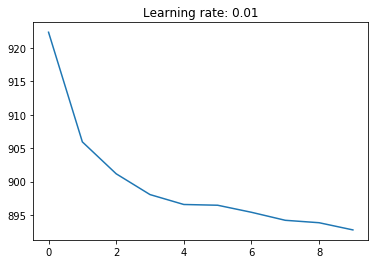

In [163]:
ep  = [i for i in range(epoch+1)]
plt.plot(ep, train_hist)
plt.title('Learning rate: '+str(learning_rate))
plt.savefig('fig1.png')

##### Task 6. Test set accuracy

In [164]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in test:
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
        total += labels.size(0)                    # Increment the total count
        correct += (predicted == labels).sum()     # Increment the correct count
    print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10K test images: 96 %


##### Task 7. Inference

In [165]:
def predict_image(image):
    image_tensor = torch.tensor(image).float().cuda()
    image_tensor = image_tensor.unsqueeze_(0)
    output = model(image_tensor)
    index = output.data.cpu().numpy().argmax()
    return index

5


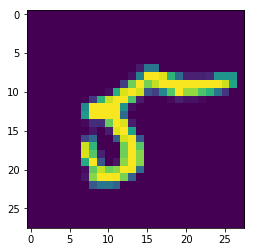

In [166]:
k = random.randint(0,9999)
testing_img = test_img[k]
testing_img = testing_img.reshape(1,1,28,28)
print(predict_image(testing_img))
plt.imshow(testing_img.squeeze())
plt.show()